# 딥러닝 분석 프로젝트
두 개의 파일(Hotel_reviews_20k.csv, Hotel_reviews.csv)을 다운 받아 20,000개 혹은 전체 147,344개의 호텔 리뷰 (review_full) 및 rating값 (rating_review)을 확인해보고 Deep learning 모델을 활용하여 분석하시오.

In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from tensorflow.keras import layers
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

## 1) 짝수 번째 행의 리뷰를 training데이터로 사용하여 모델을 만들고 홀수 번째 행의 호텔 리뷰를 가지고 rating값을 예측하는 모델을 만들어보시오.

1. 호텔 리뷰 데이터 호출

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('Hotel_reviews_20k.csv', encoding='latin1')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rating_review,review_full,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,5,Been going to honk for quite a while . This ma...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,We have been a frequent visitor at this chain ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,"Excellent staff, very cooperative and gentle ....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,I have always visit this place.they always off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Lot of appraise about Chef Deepak Chef Wangmo ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. 리뷰 데이터와 레이블 추출
- 짝수 번째 행의 리뷰를 training 데이터로 사용
- 홀수 번째 행의 리뷰를 testing 데이터로 사용

In [ ]:
X = df['review_full']
Y = df['rating_review']

train_X = X[1::2].values
train_P = Y[1::2].values

test_X = X[::2].values
test_P = Y[::2].values

train_P = train_P.reshape((len(train_P), 1))
test_P = test_P.reshape((len(test_P), 1))

3. 토큰화, 시퀀스 패딩
- 매개변수는 사용할 단어의 최대 개수는 1000개로 한다
- 상위 1000단어가 되지 않는 데이터들은 `<OOV>`로 채운다
- 문장의 최대 길이는 300단어로 한다

In [ ]:
vocab_size = 1000
embedding_dim = 20
max_length = 300
trunc_type='post'
oov_tok = '<OOV>'

# 토큰화 진행
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

# 텍스트 시퀀스를 정수 시퀀스로 변환
training_sequences = tokenizer.texts_to_sequences(train_X)
testing_sequences = tokenizer.texts_to_sequences(test_X)

# 시퀀스 패딩
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating=trunc_type)

4. 모델 구축
- 시퀀스의 길이에 관계없이 고정된 크기의 출력을 얻기 위해 `GlobalAveragePooling1D` 을 사용한다
- 활성 함수로 `relu`와 `sigmoid`를 사용한다
- 과적합 방지를 위해 dropout 레이어를 추가한다

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss_fn,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 20)           20000     
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 42)                882       
                                                                 
 dropout_1 (Dropout)         (None, 42)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 258       
                                                        

5. 모델 학습
- epochs가 30이 넘어갈 경우 과적합 상태가 되는 것을 확인하였다
- epochs는 30으로, batch size는 64로 한다

In [ ]:
history = model.fit(training_padded, train_P, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
125/125 [==============================] - 20s 140ms/step - loss: 1.5605 - accuracy: 0.3549 - val_loss: 1.4211 - val_accuracy: 0.3790
Epoch 2/30
125/125 [==============================] - 7s 52ms/step - loss: 1.4069 - accuracy: 0.4020 - val_loss: 1.3890 - val_accuracy: 0.3790
Epoch 3/30
125/125 [==============================] - 3s 22ms/step - loss: 1.3820 - accuracy: 0.4038 - val_loss: 1.3716 - val_accuracy: 0.3860
Epoch 4/30
125/125 [==============================] - 4s 34ms/step - loss: 1.3577 - accuracy: 0.4121 - val_loss: 1.3369 - val_accuracy: 0.3985
Epoch 5/30
125/125 [==============================] - 2s 17ms/step - loss: 1.3141 - accuracy: 0.4319 - val_loss: 1.2856 - val_accuracy: 0.4100
Epoch 6/30
125/125 [==============================] - 1s 11ms/step - loss: 1.2424 - accuracy: 0.4703 - val_loss: 1.2079 - val_accuracy: 0.4820
Epoch 7/30
125/125 [==============================] - 2s 12ms/step - loss: 1.1582 - accuracy: 0.5104 - val_loss: 1.1341 - val_accuracy: 0.50

6. 테스트 데이터 정확도 확인
- 정확도는 62% 이다

In [ ]:
model.evaluate(testing_padded, test_P, verbose=0)  # 0.6222000122070312

[0.9113386869430542, 0.6222000122070312]

7. 그래프로 과적합 확인하기
- val_loss는 감소, val_accuracy는 증가 추세이다
- 모델 성능이 향상되고 있음을 알 수 있다

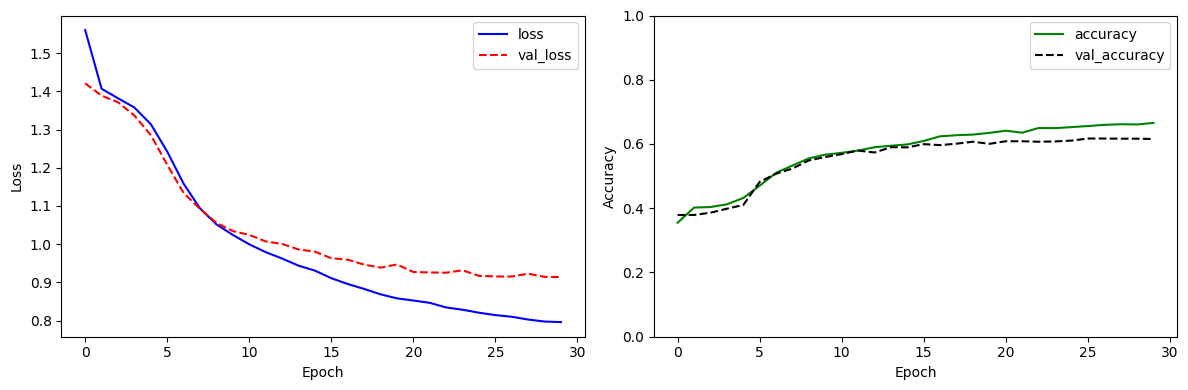

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='loss')
    plt.plot(history.history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'g-', label='accuracy')
    plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

---
## 2) 호텔의 리뷰 및 rating값을 이용하여 어떤 단어가 좋은 호텔 리뷰에 많이 쓰이고 어떤 단어가 나쁜 호텔 리뷰에 많이 쓰이는지 분석해 보고 어떤 요소가 호텔 평가에 많은 영향을 미치는지 논의해 보시오.
단어 구름에서 보듯이 good, great, best 등 긍정적인 의미 단어가 포함된 리뷰는 rating이 높고, bad, poor, worst 등 부정적인 의미 단어가 포함된 리뷰는 rating이 낮다. 해당 단어들이 좋은 리뷰와 나쁜 리뷰를 나누는 것에 가장 영향을 크게 미치는 요소라고 판단할 수 있다.

1. 불용어 처리에 필요한 NLTK 패키지 데이터 다운로드

In [ ]:
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2. 긍정적인 리뷰와 부정적인 리뷰 구분

In [ ]:
good_reviews = df[df['rating_review'] >= 4]['review_full']
bad_reviews = df[df['rating_review'] <= 2]['review_full']

3. 불용어와 문장부호를 제거
- NLTK의 `stopwords.words('english'`)를 사용하여 영어의 불용어를 제거한다
- `word.isalpha()` 조건을 사용하여 알파벳이 아닌 문자를 가지고 있는 단어는 제거한다
- `word.lower()` 조건을 사용하여 각 단어를 소문자로 변환하고, 알파벳으로만 이루어진 단어를 선택한다

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

preprocessed_good_reviews = good_reviews.apply(preprocess_text)
preprocessed_bad_reviews = bad_reviews.apply(preprocess_text)

4. 좋은 리뷰와 나쁜 리뷰의 상위 100개 단어와 빈도 계산
- 좋은 단어와 나쁜 단어 각각 상위 100개의 단어 사이에서 중복되는 단어를 구한다
- 중복되는 단어 중 good_rank(좋은 단어에서의 순위)와 bad_rand(나쁜 단어에서의 순위)를 구한다

In [ ]:
# 단어 목록
good_words = [word for sublist in preprocessed_good_reviews for word in sublist]
bad_words = [word for sublist in preprocessed_bad_reviews for word in sublist]

# 좋은 리뷰와 나쁜 리뷰 단어 빈도 계산
good_word_freq = Counter(good_words)
bad_word_freq = Counter(bad_words)

# 좋은 리뷰와 나쁜 리뷰 상위 100개 단어와 빈도
top_100_good_words = good_word_freq.most_common(100)
top_100_bad_words = bad_word_freq.most_common(100)

# 중복된 단어 리스트와 순위 출력
print("--- Duplicated Words And Their Rank ---")
duplicate_words = [word for word, _ in top_100_good_words if word in [w for w, _ in top_100_bad_words]]

for word in duplicate_words:
    good_rank = [rank for rank, (w, _) in enumerate(top_100_good_words, start=1) if w == word][0]
    bad_rank = [rank for rank, (w, _) in enumerate(top_100_bad_words, start=1) if w == word][0]
    print(f"{word} - good_rank: {good_rank}, bad_rank: {bad_rank}")

--- Duplicated Words And Their Rank ---
food - good_rank: 1, bad_rank: 1
good - good_rank: 2, bad_rank: 5
place - good_rank: 3, bad_rank: 2
service - good_rank: 4, bad_rank: 4
restaurant - good_rank: 5, bad_rank: 3
great - good_rank: 6, bad_rank: 47
one - good_rank: 7, bad_rank: 6
indian - good_rank: 8, bad_rank: 48
staff - good_rank: 10, bad_rank: 9
delhi - good_rank: 11, bad_rank: 42
nice - good_rank: 12, bad_rank: 65
visit - good_rank: 13, bad_rank: 29
also - good_rank: 14, bad_rank: 27
chicken - good_rank: 15, bad_rank: 13
really - good_rank: 16, bad_rank: 33
time - good_rank: 17, bad_rank: 11
well - good_rank: 18, bad_rank: 40
experience - good_rank: 20, bad_rank: 16
taste - good_rank: 21, bad_rank: 18
like - good_rank: 22, bad_rank: 10
menu - good_rank: 24, bad_rank: 24
us - good_rank: 25, bad_rank: 7
try - good_rank: 27, bad_rank: 88
ambience - good_rank: 29, bad_rank: 69
dishes - good_rank: 30, bad_rank: 57
would - good_rank: 31, bad_rank: 14
served - good_rank: 32, bad_rank: 2

5. 좋은 단어, 나쁜 단어 중복 제거
- good_rank(좋은 단어에서의 순위)와 bad_rand(나쁜 단어에서의 순위) 중 순위가 더 낮은 단어는 삭제한다
- 중복 단어를 제거한 후 상위 30개 단어를 구한다

In [ ]:
# 중복 제거 작업 및 상위 30개 단어 추출
ranking_good_reviews = []
ranking_bad_reviews = []
remaining_good_words = []
remaining_bad_words = []

rank = 1

for word, freq in top_100_good_words:
    if word in [w for w, _ in top_100_bad_words]:
        bad_rank = [r for r, (w, _) in enumerate(top_100_bad_words, start=1) if w == word][0]
        if rank < bad_rank:
            ranking_good_reviews.append((rank, word, freq))
            remaining_good_words.append(word)
            rank += 1
            if len(ranking_good_reviews) >= 30:
                break
    else:
        ranking_good_reviews.append((rank, word, freq))
        remaining_good_words.append(word)
        rank += 1
        if len(ranking_good_reviews) >= 30:
            break

rank = 1

for word, freq in top_100_bad_words:
    if word not in [w for w, _ in top_100_good_words]:
        ranking_bad_reviews.append((rank, word, freq))
        remaining_bad_words.append(word)
        rank += 1
        if len(ranking_bad_reviews) >= 30:
            break

In [ ]:
print("--- Top 30 Good Words ---")
for i, (rank, word, freq) in enumerate(ranking_good_reviews[:30], start=1):
    print(f"{i}. {word}({freq})")

print("\n-- Top 30 Bad Words ---")
for i, (rank, word, freq) in enumerate(ranking_bad_reviews[:30], start=1):
    print(f"{i}. {word}({freq})")

--- Top 30 Good Words ---
1. good(7358)
2. service(5006)
3. great(4188)
4. one(3499)
5. indian(2850)
6. best(2799)
7. staff(2782)
8. delhi(2717)
9. nice(2534)
10. visit(2433)
11. also(2432)
12. chicken(2391)
13. really(2379)
14. well(2241)
15. amazing(2200)
16. taste(2135)
17. excellent(1961)
18. menu(1952)
19. delicious(1877)
20. try(1864)
21. must(1843)
22. ambience(1757)
23. dishes(1696)
24. dinner(1373)
25. made(1297)
26. meal(1205)
27. love(1149)
28. chef(1095)
29. tasty(1073)
30. hotel(1072)

-- Top 30 Bad Words ---
1. bad(494)
2. asked(458)
3. never(394)
4. manager(389)
5. came(385)
6. better(374)
7. bill(362)
8. average(353)
9. got(347)
10. told(338)
11. said(331)
12. waiter(317)
13. poor(292)
14. nothing(285)
15. took(282)
16. two(272)
17. minutes(263)
18. money(261)
19. worst(254)
20. take(252)
21. serve(234)
22. however(233)
23. know(226)
24. way(217)
25. disappointed(216)
26. around(216)
27. left(215)
28. cold(215)
29. ever(214)
30. small(214)


6. 좋은 단어 그래프, 나쁜 단어 그래프

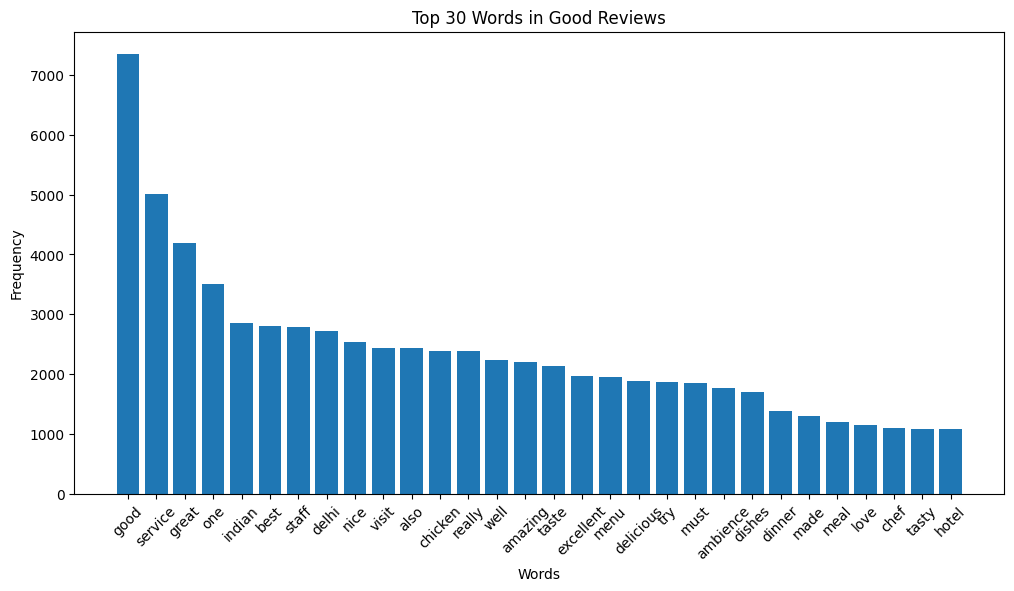

In [ ]:
# top_100_good_words 그래프
x = [word for rank, word, freq in ranking_good_reviews[:30]]
y = [freq for rank, word, freq in ranking_good_reviews[:30]]

plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.title("Top 30 Words in Good Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

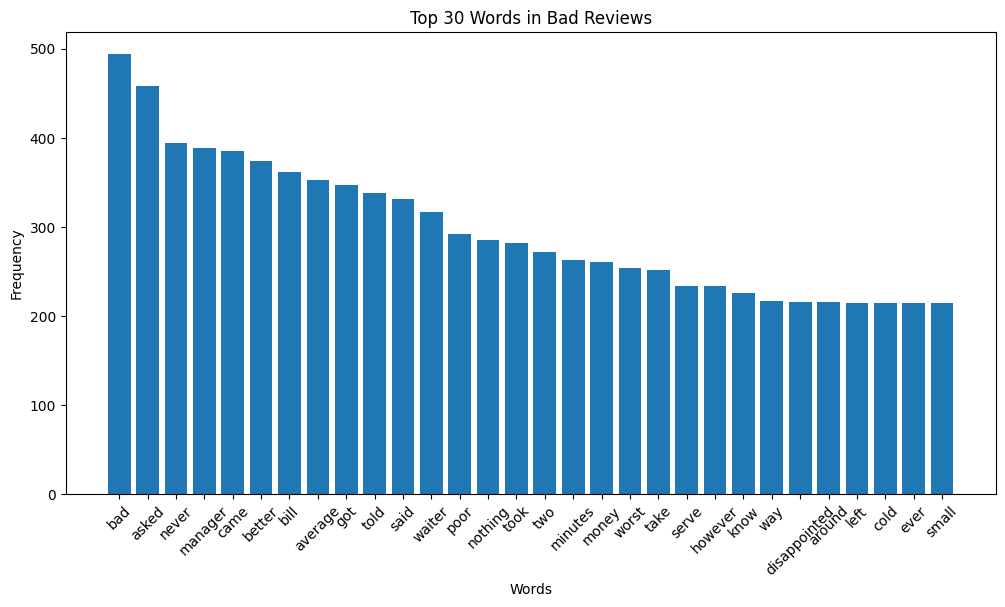

In [ ]:
# top_100_bad_words 그래프
x = [word for rank, word, freq in ranking_bad_reviews[:30]]
y = [freq for rank, word, freq in ranking_bad_reviews[:30]]

plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.title("Top 30 Words in Bad Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

7. 좋은 단어, 나쁜 단어 Word Cloud
- 좋은 단어 구름에서 good, great, best 등 긍정적인 의미 단어들을 볼 수 있다
- 나쁜 단어 구름에서 bad, poor, worst 등 부정적인 의미 단어들을 볼 수 있다

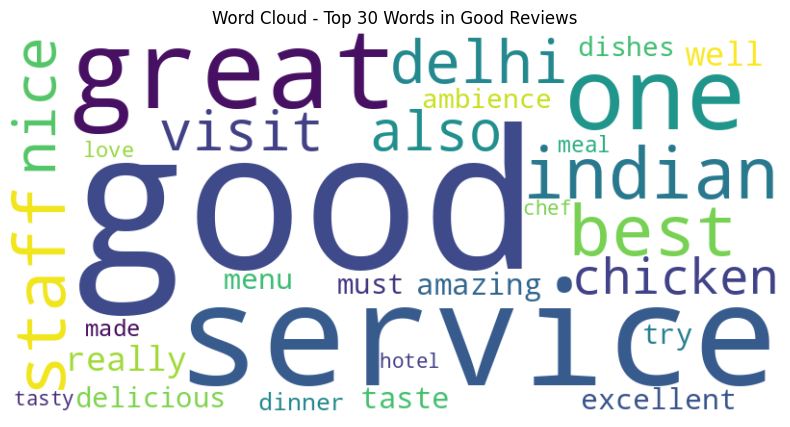

In [ ]:
word_freq_dict = {word: freq for rank, word, freq in ranking_good_reviews[:30]}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Top 30 Words in Good Reviews")
plt.show()

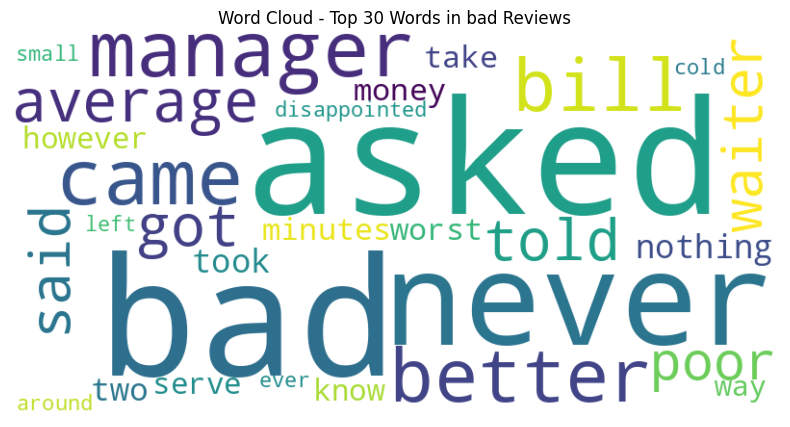

In [ ]:
word_freq_dict = {word: freq for rank, word, freq in ranking_bad_reviews[:30]}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Top 30 Words in bad Reviews")
plt.show()

8. 감성 점수 계산
- 감성 점수는 -1부터 1까지의 범위를 가진다. -1에 가까울수록 강한 부정적인 감정, 1에 가까울수록 강한 긍정적인 감정을 나타낸다
- Good Reviews 감정 점수 분포는 1에 가까운 분포를 보인다. 대부분의 리뷰가 강한 긍정의 감정을 담고 있음을 알 수 있다
- Bad Reviews 감정 점수 분포는 -1에 가까운 분포를 보인다. 대부분의 리뷰가 강한 부정의 감정을 담고 있음을 알 수 있다
- Bad Reviews 감정 점수 분포가 Good Reviews 감정 점수 분포에 비해 상대적으로 완만한 분포가 보이는 것은 긍정적인 리뷰에 비해 데이터가 적기 때문이라 추측한다

In [ ]:
sia = SentimentIntensityAnalyzer()  # 감성 분석기 초기화

good_reviews_scores = [sia.polarity_scores(review)['compound'] for review in good_reviews]
bad_reviews_scores = [sia.polarity_scores(review)['compound'] for review in bad_reviews]

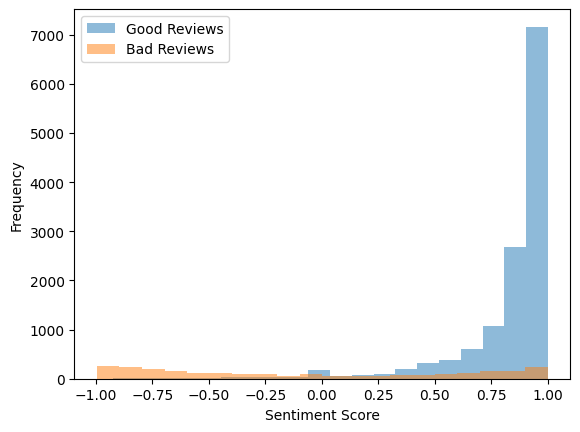

In [ ]:
plt.hist(good_reviews_scores, bins=20, alpha=0.5, label='Good Reviews')
plt.hist(bad_reviews_scores, bins=20, alpha=0.5, label='Bad Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()